# **User Preference-aware Fake News Detection**



* [https://github.com/balian729/fake_news_detection](https://github.com/balian729/fake_news_detection)

## **Team members**


<table>
  <tr>
   <td><strong>Name</strong>
   </td>
   <td><strong>Email</strong>
   </td>
   <td><strong>Alias</strong>
   </td>
  </tr>
  <tr>
   <td>Elaman Turekulov
   </td>
   <td>e.turekulov@innopolis.university
   </td>
   <td>@bal1an
   </td>
  </tr>
  <tr>
   <td>Dmitrii Naumov
   </td>
   <td>d.naumov@innopolis.university
   </td>
   <td>@DmitryNau
   </td>
  </tr>
  <tr>
   <td>Albert Khazipov
   </td>
   <td>a.khazipov@innopolis.university
   </td>
   <td>@drxelt
   </td>
  </tr>
</table>

## **Problem statement**

In this day and age, when people get most of the news from the internet, where the sources cannot always be credible, the spread of fake news became a significant issue. With the exponential growth of social media platforms and online news sources, identifying and mitigating the impact of false information has become a daunting challenge. Traditional methods of fake news detection often fall short in handling the dynamic and evolving nature of deceptive content.

## **Solution description**

In this context, leveraging Graph Machine Learning (Graph ML) techniques for fake news detection presents a promising avenue. Graph ML enables the representation of relationships and interactions among entities, making it well-suited for capturing the intricate patterns of information propagation and source credibility in online networks.

In our project, we tried to develop a model that will be able to detect fake news and for this, we decided to use UPFD[1] dataset and compared the performance of different models on this dataset

## **Dataset**

The dataset consists of Twitter networks that propagate both fake and real news, constructed based on fact-check information from Politifact[2] and Gossipcop[3]. The retweet graphs for the news were initially obtained using FakeNewsNet[4]. The dataset's statistics are presented below:


<table>
  <tr>
   <td><strong>Data</strong>
   </td>
   <td><strong>#Graphs</strong>
   </td>
   <td><strong>#Fake News</strong>
   </td>
   <td><strong>#Total Nodes</strong>
   </td>
   <td><strong>#Total Edges</strong>
   </td>
   <td><strong>#Avg. Nodes per Graph</strong>
   </td>
  </tr>
  <tr>
   <td>Politifact
   </td>
   <td>314
   </td>
   <td>157
   </td>
   <td>41,054
   </td>
   <td>40,740
   </td>
   <td>131
   </td>
  </tr>
  <tr>
   <td>Gossipcop
   </td>
   <td>5464
   </td>
   <td>2732
   </td>
   <td>314,262
   </td>
   <td>308,798
   </td>
   <td>58
   </td>
  </tr>
</table>


In our case, we used only Politifact as our dataset, since Gossipcop was too large and required much more computational resources.

Please keep in mind that there are **four node feature types** in the dataset. The 768-dimensional BERT and 300-dimensional spaCy features are encoded using pretrained models from BERT[5] and spaCy[6] word2vec, respectively. Additionally, the 10-dimensional profile feature is derived from profiles of  Twitter accounts, and content feature that is a combination of spacy and profile features


## **What is Graph ML and PyG?**

So, what is Graph ML? Think of Graph ML as a way to teach computers about relationships and connections. In real-world problems, things are often connected or related to each other, like friends in a social network or molecules in chemistry. Graph ML helps computers understand and make predictions based on these connections.

A graph consists of nodes (representing entities) and edges (representing relationships between entities). Each node and edge can have associated attributes. There are many different Graph ML models, and those of them that were used in this project, I am going to explain further down below.

And what is PyG? PyG is an acronym for PyTorch Geometric, which is an extension library for PyTorch specifically tailored for dealing with graph-structured data. It provides abstractions for handling graphs, creating graph datasets, and implementing various graph neural network layers.

Key features of PyG:

* **Data Handling**: PyG provides a `Data` class to manage node and edge attributes, making it easy to work with graph data.
* **Graph Convolutional Layers**: PyG includes various graph convolutional layers, such as Graph Convolutional Networks (GCNs), GraphSAGE, etc., simplifying the implementation of GNNs.
* **Dataset Loading**: PyG includes datasets for common benchmarks, simplifying the process of loading and working with well-known graph datasets.

# First steps
First of all, clone the repository and install requirements.txt

In [15]:
!apt-get install -y git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Updated git hooks.
Git LFS initialized.


In [16]:
!git lfs clone https://github.com/balian729/fake_news_detection.git
%cd fake_news_detection
!pip install -r requirements.txt

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'fake_news_detection'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 576 (delta 23), reused 124 (delta 14), pack-reused 436
Receiving objects: 100% (576/576), 85.56 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/fake_news_detection/fake_news_detection
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
  Using cached beautifulsoup4-4.12.2-py3-none-any.whl (142 kB)
  Using cached cssutils-2.9.0-py3-none-any.whl (398 kB)
  Using cached dataframe_image-0.2.3-py3-none-any.whl (6.7 MB)
  Using cached fsspec-2023.12.2-py3-none-any.whl (168 kB)
  Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached html2image-2.0.4.3-py3-none-any.whl (27 kB)
  Using cached jso

In [17]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


In [18]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GATConv
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch_geometric.nn import global_max_pool as gmp

## **Node feature types**

There are node four feature types that were used, each introducing their own set of features based on the selected approach

* **bert** - 768-dimensional feature type which is encoded using pretrained BERT
* **spacy** - 300-dimensional feature type which is encoded using pretrained spaCy word2vec, respectively
* **profile** - 10-dimensional feature type which represents data taken from Twitter accounts. This data include: verified status(binary), geo-spatial positioning(binary), the amount of followers and friends, date of account creation, etc.
* **content** - a combination of two other node feature types:  
    * 300-dimensional `spacy`, capturing semantic content.
    * 10-dimensional `profile`, providing additional user-specific information.

## **Models and techniques**
### **GCN**

GCN stands for Graph Convolutional Network, and it's a type of neural network architecture designed to work with graph-structured data.

#### **Graph Convolution Operation:**
**Transformation of Node Features:**
  - Each node is associated with a feature vector. In the case of the first layer, these are the initial node features.
  - A weight matrix is applied to these features, similar to the weight matrices in traditional neural network layers.

$Z = \sigma(A \cdot X \cdot W_1)$

where:
  - $X$ is the input node features matrix.
  - $W_1$ is the weight matrix for the first layer.
  - $A$ is the adjacency matrix.
  - $\sigma$ is the activation function.

**Aggregation of Neighboring Information:**

* The convolutional operation aggregates information from neighboring nodes.
* This is achieved by multiplying the adjacency matrix A with the transformed node features Z.

$Z' = \sigma(A \cdot Z \cdot W_2)$

where:
 - $W_2$ is the weight matrix for the second layer.

**Output:**
The result $Z'$ represents the new features of each node after considering information from its neighbors.

#### **Training**
Training a GCN involves optimizing the weights $W_1$ and $W_2$ to minimize a specific loss function for the task at hand. Commonly used loss functions include cross-entropy for classification tasks or mean squared error for regression tasks.

### **GAT**

The Graph Attention Network (GAT) is a type of neural network architecture designed for graph-structured data. In the context of GAT, a graph is represented as a set of nodes and edges. Each node in the graph corresponds to an entity, and edges represent relationships or connections between entities.

The core idea behind GAT is the use of attention mechanisms. Attention mechanisms allow the model to focus on different parts of the input when making predictions, mimicking the human attention process. GAT employs a self-attention mechanism, where each node can attend to its neighbors with different attention weights. This allows the model to assign different importance to different neighbors during information aggregation.

GAT computes a node's representation by aggregating information from its neighbors. The aggregation is done using attention weights, which are learned during training. The node representations are computed as a weighted sum of the neighboring node features, where the attention weights are determined by the compatibility between the node and its neighbors.

GAT extends the basic attention mechanism by using multiple attention heads. Each attention head learns a different set of attention weights, capturing different aspects of the relationships between nodes. The outputs of multiple attention heads are concatenated or averaged to produce the final node representations.

Given a graph with nodes represented by feature vectors, the GAT operation for computing the output features of a node involves computing attention coefficients, applying them to the corresponding neighbor node features, and aggregating the results.

In [19]:
# Define a class named SimpleGNN that inherits from torch.nn.Module
class SimpleGNN(torch.nn.Module):
    # Constructor method, initializes the object with given arguments
    def __init__(self, args):
        super(SimpleGNN, self).__init__()

        # Assign arguments to object attributes
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.model = args.model
        self.concat = args.concat

        # Conditional block to choose the appropriate convolution layer based on the specified model
        if self.model == 'gcn':
            self.conv1 = GCNConv(self.num_features, self.nhid)
        elif self.model == 'graphsage':
            self.conv1 = SAGEConv(self.num_features, self.nhid)
        elif self.model == 'gat':
            self.conv1 = GATConv(self.num_features, self.nhid)

        # Additional layers for concatenation, if specified
        if self.concat:
            self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
            self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

        # Output layer
        self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

    # Forward method defines the forward pass of the neural network
    def forward(self, data):
        # Extract input data components
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None  # Optional edge attributes

        # Apply the selected convolution layer and activation function
        x = F.relu(self.conv1(x, edge_index, edge_attr))

        # Perform graph-level pooling using global max pooling
        x = gmp(x, batch)

        # If concatenation is specified, perform additional operations
        if self.concat:
            # Extract node features based on batch indices and stack them
            news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
            # Apply linear layer and activation function
            news = F.relu(self.lin0(news))
            # Concatenate global and local features
            x = torch.cat([x, news], dim=1)
            # Apply another linear layer and activation function
            x = F.relu(self.lin1(x))

        # Apply the final linear layer and log softmax activation for classification
        x = F.log_softmax(self.lin2(x), dim=-1)

        return x  # Return the output


### **GraphSAGE**

GraphSAGE, which stands for Graph Sample and Aggregated (SAGE), is a graph neural network (GNN) architecture designed for learning node embeddings in a graph. The main objective of GraphSAGE is to learn a function that generates embeddings for nodes in a graph in an inductive manner. In other words, it aims to produce embeddings for nodes that were not seen during training, enabling the model to generalize to unseen nodes.


#### **Graph Convolution**:
GraphSAGE utilizes a graph convolutional operation to aggregate information from a node's local neighborhood. Unlike traditional convolutional operations in image processing, graph convolutional operations consider the graph structure.


#### **Aggregation Strategy**

The key innovation of GraphSAGE lies in its sampling and aggregation strategy. Rather than aggregating information from all neighboring nodes, which could be computationally expensive for large graphs, GraphSAGE samples a fixed-size neighborhood around each node.

1. **Sampling**: For each node, a fixed-size sample of its neighbors is chosen. The sampling strategy can be random, but it's often guided by a more structured approach like sampling neighbors from a fixed radius or using a specific sampling algorithm.

2. **Aggregation**: The sampled node features are then aggregated to create a representative vector for the node. This aggregation process is typically a differentiable operation, and it allows the model to learn how to combine information from the neighborhood.

#### **GraphSAGE Architecture:**

The GraphSAGE model typically consists of multiple layers of the sampling and aggregation process. The output of each layer is used as the input for the next layer. The final layer's output represents the node embeddings.

In [20]:
# Define a class named SimpleGNN that inherits from torch.nn.Module
class SimpleGNN(torch.nn.Module):
    # Constructor method, initializes the object with given arguments
    def __init__(self, args):
        super(SimpleGNN, self).__init__()

        # Assign arguments to object attributes
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.model = args.model
        self.concat = args.concat

        # Conditional block to choose the appropriate convolution layer based on the specified model
        if self.model == 'gcn':
            self.conv1 = GCNConv(self.num_features, self.nhid)
        elif self.model == 'graphsage':
            self.conv1 = SAGEConv(self.num_features, self.nhid)
        elif self.model == 'gat':
            self.conv1 = GATConv(self.num_features, self.nhid)

        # Additional layers for concatenation, if specified
        if self.concat:
            self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
            self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

        # Output layer
        self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

    # Forward method defines the forward pass of the neural network
    def forward(self, data):
        # Extract input data components
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None  # Optional edge attributes

        # Apply the selected convolution layer and activation function
        x = F.relu(self.conv1(x, edge_index, edge_attr))

        # Perform graph-level pooling using global max pooling
        x = gmp(x, batch)

        # If concatenation is specified, perform additional operations
        if self.concat:
            # Extract node features based on batch indices and stack them
            news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
            # Apply linear layer and activation function
            news = F.relu(self.lin0(news))
            # Concatenate global and local features
            x = torch.cat([x, news], dim=1)
            # Apply another linear layer and activation function
            x = F.relu(self.lin1(x))

        # Apply the final linear layer and log softmax activation for classification
        x = F.log_softmax(self.lin2(x), dim=-1)

        return x  # Return the output


### **GCNFN [7]**
GCNFN is implemented using two GCN layers and one mean-pooling layer as the graph encoder;
the 310-dimensional node feature (args.feature = content) is composed of 300-dimensional
comment word2vec (spaCy) embeddings plus 10-dimensional profile features

In [21]:
# Define a class named GCNFN that inherits from torch.nn.Module
class GCNFN(torch.nn.Module):
    """
    Implementation of Fake News Detection on Social Media using Geometric Deep Learning.
    Paper: Fake News Detection on Social Media using Geometric Deep Learning
    Link: https://arxiv.org/pdf/1902.06673.pdf
    """

    # Constructor method, initializes the object with given arguments
    def __init__(self, args):
        super(GCNFN, self).__init__()

        # Assign arguments to object attributes
        self.num_features = args.num_features
        self.num_classes = args.num_classes
        self.nhid = args.nhid
        self.concat = args.concat

        # Define the first and second graph attention layers
        self.conv1 = GATConv(self.num_features, self.nhid * 2)
        self.conv2 = GATConv(self.nhid * 2, self.nhid * 2)

        # Define the first fully connected layer
        self.fc1 = Linear(self.nhid * 2, self.nhid)

        # Additional layers for concatenation, if specified
        if self.concat:
            self.fc0 = Linear(self.num_features, self.nhid)
            self.fc1 = Linear(self.nhid * 2, self.nhid)

        # Output layer
        self.fc2 = Linear(self.nhid, self.num_classes)

    # Forward method defines the forward pass of the neural network
    def forward(self, data):
        # Extract input data components
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply the first and second graph attention layers with SELU activation
        x = F.selu(self.conv1(x, edge_index))
        x = F.selu(self.conv2(x, edge_index))

        # Global mean pooling operation
        x = F.selu(global_mean_pool(x, batch))

        # Apply the first fully connected layer with SELU activation
        x = F.selu(self.fc1(x))

        # Apply dropout for regularization
        x = F.dropout(x, p=0.5, training=self.training)

        # If concatenation is specified, perform additional operations
        if self.concat:
            # Extract node features based on batch indices and stack them
            news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
            # Apply linear layer and activation function
            news = F.relu(self.fc0(news))
            # Concatenate global and local features
            x = torch.cat([x, news], dim=1)
            # Apply another linear layer and activation function
            x = F.relu(self.fc1(x))

        # Apply the final linear layer and log softmax activation for classification
        x = F.log_softmax(self.fc2(x), dim=-1)

        return x  # Return the output


## **Metrics**
To evaluate the performance of our models, we used four different metrics: These metrics being accuracy, AUC, F1 score and loss. Below you can see how each metric is calculated and the reasoning behind its selection.

### Accuracy
As you know, accuracy is one of the most basic metrics and can be simply calculated as (# of correct predictions)/(total prediction number). The reason behind choosing it as it is the most simple metric that allows any person to clearly understand the performance of our models. It is also worth mentioning that our dataset is fairly balanced, with fake news making up ~40% of the dataset, and real news being ~60%, respectively.
### AUC
As it is known AUC stands for Area Under ROC Curve, ROC here meaning Receiver Operating Characteristic, which is sometimes called an “error curve”. We decided to chose that metric as it is excellent for binary classification and suits a slight imbalance in our data
### F1 score
F1 score is one of the most used evaluation metrics as it integrates precision and recall into a single metric to gain a better understanding of model performance. It’s calculated as follows:
F1 = (2 * _Precision_ * _Recall_)(_Precision_ + _Recall_)

In [22]:
# Import necessary libraries and modules
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score
)

def eval_deep(log, loader):
    """
    Evaluate the performance of a deep learning model on a given dataset using various metrics.

    Args:
        log (list): List containing predictions and ground truth for each batch.
        loader (torch.utils.data.DataLoader): Data loader for the evaluation dataset.

    Returns:
        list: List containing accuracy, F1 score, precision, recall, and AUC.

    """
    # Calculate the total size of the evaluation dataset and batch size
    data_size = len(loader.dataset.indices)
    batch_size = loader.batch_size

    # Create a list specifying the size of each batch
    if data_size % batch_size == 0:
        size_list = [batch_size] * (data_size // batch_size)
    else:
        size_list = [batch_size] * (data_size // batch_size) + [data_size % batch_size]

    # Ensure the lengths of the log and size_list are the same
    assert len(log) == len(size_list)

    # Initialize variables to store aggregated metrics
    accuracy, f1, precision, recall = 0, 0, 0, 0

    # Lists to store probability and label information
    prob_log, label_log = [], []

    # Iterate through each batch in the log and calculate metrics
    for batch, size in zip(log, size_list):
        pred_y = batch[0].data.cpu().numpy().argmax(axis=1)
        y = batch[1].data.cpu().numpy().tolist()

        # Extend probability and label lists
        prob_log.extend(batch[0].data.cpu().numpy()[:, 1].tolist())
        label_log.extend(y)

        # Update aggregated metrics
        accuracy += accuracy_score(y, pred_y) * size
        f1 += f1_score(y, pred_y, average='binary') * size
        precision += precision_score(y, pred_y, zero_division=0) * size
        recall += recall_score(y, pred_y, zero_division=0) * size

    # Calculate AUC using sklearn's roc_auc_score
    auc = roc_auc_score(label_log, prob_log)

    # Return a list of normalized metrics
    return [accuracy / data_size, f1 / data_size, precision / data_size, recall / data_size, auc]

def compute_test(model, loader, device=torch.device('cpu'), verbose=False):
    """
    Evaluate a deep learning model on a test dataset and compute various metrics.

    Args:
        model (torch.nn.Module): Deep learning model to be evaluated.
        loader (torch.utils.data.DataLoader): Data loader for the test dataset.
        device (torch.device): Device to which the model and data should be moved.
        verbose (bool): If True, print softmax probabilities for each batch.

    Returns:
        list: List containing accuracy, F1 score, precision, recall, AUC, and loss.

    """
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Initialize test loss
        loss_test = 0.0
        out_log = []  # List to store predictions and ground truth for each batch

        # Iterate through batches in the test dataset
        for data in loader:
            # Move data to the specified device
            data = data.to(device)

            # Forward pass through the model
            out = model(data)
            y = data.y  # Ground truth labels

            # Print softmax probabilities if verbose is True
            if verbose:
                print(F.softmax(out, dim=1).cpu().numpy())

            # Append predictions and ground truth to the out_log list
            out_log.append([F.softmax(out, dim=1), y])

            # Calculate and accumulate the test loss
            loss_test += F.nll_loss(out, y).item()

        # Average the test loss over all batches
        loss_test /= len(loader)

        # Call eval_deep to calculate and return evaluation metrics
        res = eval_deep(out_log, loader)
        res.append(loss_test)

    # Return the list of metrics
    return res


In [23]:
# Import necessary libraries and modules
from tqdm import trange

def train(model, train_loader, val_loader, args):
	"""
	Train a deep learning model using the specified training and validation loaders.

	Args:
		model (torch.nn.Module): Deep learning model to be trained.
		train_loader (torch.utils.data.DataLoader): Data loader for the training dataset.
		val_loader (torch.utils.data.DataLoader): Data loader for the validation dataset.
		args (Namespace): Command-line arguments.

	Returns:
		dict: Dictionary containing the best achieved metrics on the validation set.

	"""
	# Initialize Adam optimizer with specified learning rate and weight decay
	optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

	# Set the model to training mode
	model.train()

	# Lists with data for plotting
	train_loss_list = []
	val_loss_list = []

	train_acc_list = []
	val_acc_list = []

	train_auc_list = []
	val_auc_list = []

	train_f1_list = []
	val_f1_list = []
	# Initialize variables to track best validation loss and corresponding metrics
	best_loss_val = 1e9
	best_metrics = {
		"acc": 0,
		"auc": 0,
		"loss": 0,
		"F1": 0
	}

	# Create a tqdm progress bar for training epochs
	loop = trange(args.epochs)

	# Loop through training epochs
	for _ in loop:
		out_log = []  # List to store predictions and ground truth for each training batch
		loss_train = 0.0  # Initialize training loss

		# Iterate through batches in the training dataset
		for i, data in enumerate(train_loader):
			optimizer.zero_grad()  # Zero the gradients
			data = data.to(args.device)  # Move data to the specified device
			out = model(data)  # Forward pass
			y = data.y  # Ground truth labels
			loss = F.nll_loss(out, y)  # Calculate loss
			loss.backward()  # Backward pass
			optimizer.step()  # Update weights
			loss_train += loss.item()  # Accumulate training loss
			out_log.append([F.softmax(out, dim=1), y])  # Append predictions and labels

		# Evaluate metrics on the training set
		acc_train, f1_train, _, recall_train, auc_train = eval_deep(out_log, train_loader)

		# Evaluate metrics on the validation set
		[acc_val, f1_val, _, recall_val, auc_val, loss_val] = compute_test(model, val_loader, args.device)

		# Update tqdm description with the latest validation loss
		loop.set_description(f"Validation Loss: {loss_val:.4f}")

		# Check if the current validation loss is the best so far
		if loss_val < best_loss_val:
			best_loss_val = loss_val
			best_metrics["acc"] = acc_val
			best_metrics["auc"] = auc_val
			best_metrics["F1"] = f1_val
			best_metrics["loss"] = loss_val
			torch.save(model.state_dict(), f'models/weights/{args.model}_best.pth')

		train_loss_list.append(loss_train)
		val_loss_list.append(loss_val)

		train_acc_list.append(acc_train)
		val_acc_list.append(acc_val)

		train_auc_list.append(auc_train)
		val_auc_list.append(auc_val)

		train_f1_list.append(f1_train)
		val_f1_list.append(f1_val)

	x = range(args.epochs)

	fig, axs = plt.subplots(2, 2, figsize=(10, 8))
	axs[0, 0].plot(x, train_loss_list, label='train')
	axs[0, 0].plot(x, val_loss_list, label='val')
	axs[0, 0].set_title('Train Validation loss')
	axs[0, 0].legend()

	axs[0, 1].plot(x, train_acc_list, label='train')
	axs[0, 1].plot(x, val_acc_list, label='val')
	axs[0, 1].set_title('Train Validation Accuracy')
	axs[0, 1].legend()

	axs[1, 0].plot(x, train_auc_list, label='train')
	axs[1, 0].plot(x, val_auc_list, label='val')
	axs[1, 0].set_title('Train Validation AUC')
	axs[1, 0].legend()

	axs[1, 1].plot(x, train_f1_list, label='train')
	axs[1, 1].plot(x, val_f1_list, label='val')
	axs[1, 1].set_title('Train Validation F1')
	axs[1, 1].legend()

	# Adjust layout to prevent clipping of titles and labels
	plt.tight_layout()

	# Show the plot
	plt.show()
	# Return the best achieved metrics on the validation set
	return best_metrics


In [24]:
feature = 'bert'
train_size = 0.6
val_size = 0.2
batch_size = 128
model = 'gcnfn'

In [25]:
class Arguments:
    def __init__(self,
                device='cuda:0',
                batch_size=128,
                train_size=0.6,
                val_size=0.2,
                lr=0.001,
                weight_decay=0.01,
                nhid=128,
                epochs=100,
                concat=False,
                feature='spacy',
                model='gcnfn') -> None:
        self.device = device
        self.batch_size = batch_size
        self.train_size = train_size
        self.val_size = val_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.nhid = nhid
        self.epochs = epochs
        self.concat = concat
        self.feature = feature
        self.model = model

In [26]:
args = Arguments(feature=feature,
                 model=model,
                 batch_size=batch_size,
                 train_size=train_size,
                 val_size=val_size)

# Dataset
This code was inspired by https://github.com/safe-graph/GNN-FakeNews

In [27]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import to_undirected, add_self_loops
from torch_sparse import coalesce
from torch_geometric.io import read_txt_array
import random
import numpy as np
import scipy.sparse as sp

"""
	Functions to help load the graph data
"""

def read_file(folder, name, dtype=None):
	path = os.path.join(folder, '{}.txt'.format(name))
	return read_txt_array(path, sep=',', dtype=dtype)


def split(data, batch):
	"""
	PyG util code to create graph batches
	"""

	node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
	node_slice = torch.cat([torch.tensor([0]), node_slice])

	row, _ = data.edge_index
	edge_slice = torch.cumsum(torch.from_numpy(np.bincount(batch[row])), 0)
	edge_slice = torch.cat([torch.tensor([0]), edge_slice])

	# Edge indices should start at zero for every graph.
	data.edge_index -= node_slice[batch[row]].unsqueeze(0)
	data.__num_nodes__ = torch.bincount(batch).tolist()

	slices = {'edge_index': edge_slice}
	if data.x is not None:
		slices['x'] = node_slice
	if data.edge_attr is not None:
		slices['edge_attr'] = edge_slice
	if data.y is not None:
		if data.y.size(0) == batch.size(0):
			slices['y'] = node_slice
		else:
			slices['y'] = torch.arange(0, batch[-1] + 2, dtype=torch.long)

	return data, slices


def read_graph_data(folder, feature):
	"""
	PyG util code to create PyG data instance from raw graph data
	"""

	node_attributes = sp.load_npz(folder + f'new_{feature}_feature.npz')
	edge_index = read_file(folder, 'A', torch.long).t()
	node_graph_id = np.load(folder + 'node_graph_id.npy')
	graph_labels = np.load(folder + 'graph_labels.npy')


	edge_attr = None
	x = torch.from_numpy(node_attributes.todense()).to(torch.float)
	node_graph_id = torch.from_numpy(node_graph_id).to(torch.long)
	y = torch.from_numpy(graph_labels).to(torch.long)
	_, y = y.unique(sorted=True, return_inverse=True)

	num_nodes = edge_index.max().item() + 1 if x is None else x.size(0)
	edge_index, edge_attr = add_self_loops(edge_index, edge_attr)
	edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes, num_nodes)

	data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
	data, slices = split(data, node_graph_id)

	return data, slices


class ToUndirected:
	def __init__(self):
		"""
		PyG util code to transform the graph to the undirected graph
		"""
		pass

	def __call__(self, data):
		edge_attr = None
		edge_index = to_undirected(data.edge_index, data.x.size(0))
		num_nodes = edge_index.max().item() + 1 if data.x is None else data.x.size(0)
		# edge_index, edge_attr = add_self_loops(edge_index, edge_attr)
		edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes, num_nodes)
		data.edge_index = edge_index
		data.edge_attr = edge_attr
		return data



class FNNDataset(InMemoryDataset):
	"""
		The Graph datasets built upon FakeNewsNet data

	Args:
		root (string): Root directory where the dataset should be saved.
		name (string): The `name
			<https://chrsmrrs.github.io/datasets/docs/datasets/>`_ of the
			dataset.
		transform (callable, optional): A function/transform that takes in an
			:obj:`torch_geometric.data.Data` object and returns a transformed
			version. The data object will be transformed before every access.
			(default: :obj:`None`)
		pre_transform (callable, optional): A function/transform that takes in
			an :obj:`torch_geometric.data.Data` object and returns a
			transformed version. The data object will be transformed before
			being saved to disk. (default: :obj:`None`)
		pre_filter (callable, optional): A function that takes in an
			:obj:`torch_geometric.data.Data` object and returns a boolean
			value, indicating whether the data object should be included in the
			final dataset. (default: :obj:`None`)
	"""

	def __init__(self, root, name, feature='spacy', empty=False, transform=None, pre_transform=None, pre_filter=None):
		self.name = name
		self.root = root
		self.feature = feature
		super(FNNDataset, self).__init__(root, transform, pre_transform, pre_filter)
		if not empty:
			self.data, self.slices, self.train_idx, self.val_idx, self.test_idx = torch.load(self.processed_paths[0])

	@property
	def raw_dir(self):
		name = 'raw/'
		return os.path.join(self.root, self.name, name)

	@property
	def processed_dir(self):
		name = 'processed/'
		return os.path.join(self.root, self.name, name)

	@property
	def num_node_attributes(self):
		if self.data.x is None:
			return 0
		return self.data.x.size(1)

	@property
	def raw_file_names(self):
		names = ['node_graph_id', 'graph_labels']
		return ['{}.npy'.format(name) for name in names]

	@property
	def processed_file_names(self):
		if self.pre_filter is None:
			return f'{self.name[:3]}_data_{self.feature}.pt'
		else:
			return f'{self.name[:3]}_data_{self.feature}_prefiler.pt'

	def download(self):
		raise NotImplementedError('Must indicate valid location of raw data. No download allowed')

	def process(self):

		self.data, self.slices = read_graph_data(self.raw_dir, self.feature)

		if self.pre_filter is not None:
			data_list = [self.get(idx) for idx in range(len(self))]
			data_list = [data for data in data_list if self.pre_filter(data)]
			self.data, self.slices = self.collate(data_list)

		if self.pre_transform is not None:
			data_list = [self.get(idx) for idx in range(len(self))]
			data_list = [self.pre_transform(data) for data in data_list]
			self.data, self.slices = self.collate(data_list)

		# The fixed data split for benchmarking evaluation
		# train-val-test split is 20%-10%-70%
		self.train_idx = torch.from_numpy(np.load(self.raw_dir + 'train_idx.npy')).to(torch.long)
		self.val_idx = torch.from_numpy(np.load(self.raw_dir + 'val_idx.npy')).to(torch.long)
		self.test_idx = torch.from_numpy(np.load(self.raw_dir + 'test_idx.npy')).to(torch.long)

		torch.save((self.data, self.slices, self.train_idx, self.val_idx, self.test_idx), self.processed_paths[0])

	def __repr__(self):
		return '{}({})'.format(self.name, len(self))

Processing...
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Validation Loss: 0.4844: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


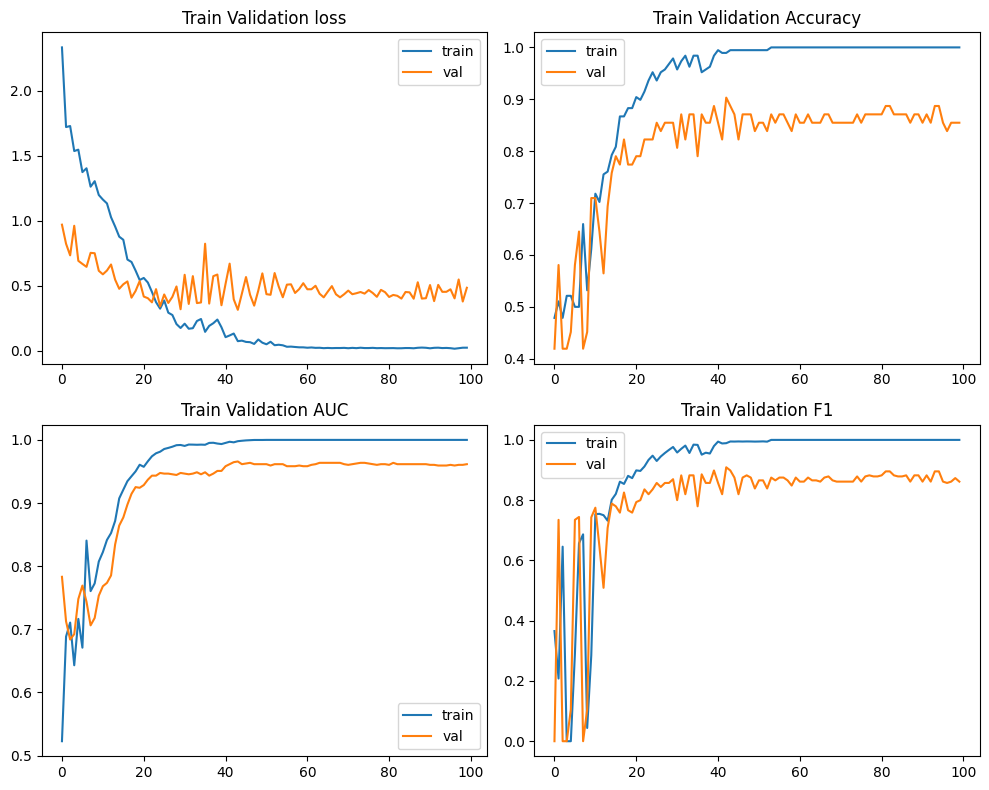

Validation Results
+----+----------+----------+----------+----------+
|    |      acc |      auc |     loss |       F1 |
|----+----------+----------+----------+----------|
|  0 | 0.887097 | 0.965812 | 0.314863 | 0.898551 |
+----+----------+----------+----------+----------+
Test Results
+----+------------+---------+-------------+----------+----------+----------+
|    |   Accuracy |      F1 |   Precision |   Recall |      AUC |     Loss |
|----+------------+---------+-------------+----------+----------+----------|
|  0 |    0.84375 | 0.83871 |     0.83871 |  0.83871 | 0.889541 | 0.524673 |
+----+------------+---------+-------------+----------+----------+----------+


In [28]:
# Import necessary libraries and modules
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
from tabulate import tabulate
import pandas as pd

# Set a seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create a dataset instance for Fake News Detection
dataset = FNNDataset(root='./data', feature=args.feature, empty=False, name='politifact', transform=ToUndirected())

# Update the number of classes and features in the command-line arguments based on the dataset
args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

# Print the updated command-line arguments
print(args)

# Split the dataset into training, validation, and test sets
num_training = int(len(dataset) * args.train_size)
num_val = int(len(dataset) * args.val_size)
num_test = len(dataset) - (num_training + num_val)

training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

# Create DataLoader instances for training, validation, and test sets
train_loader = DataLoader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

# Choose the model based on the specified architecture in command-line arguments
if args.model == 'gcnfn':
    model = GCNFN(args=args)
else:
    model = SimpleGNN(args)
model = model.to(args.device)

# Train the model on the training set and obtain the best validation results
best_results = train(model, train_loader, val_loader, args)
best_results_df = pd.DataFrame([best_results])

# Print the best validation results using tabulate for a formatted display
print("Validation Results")
print(tabulate(best_results_df, headers='keys', tablefmt='psql'))

# Evaluate the model on the test set and obtain the test results
model.load_state_dict(torch.load(f'./models/weights/{args.model}_best.pth'))
test_results = compute_test(model, test_loader, args.device, verbose=False)
test_results_df = pd.DataFrame([test_results], columns=["Accuracy", "F1", "Precision", "Recall", "AUC", "Loss"])

# Print the test results using tabulate for a formatted display
print("Test Results")
print(tabulate(test_results_df, headers='keys', tablefmt='psql'))


# Conclusion
In this notebook, we introduced a geometric deep learning method designed for identifying fake news within the Twitter social network. The proposed approach naturally enables the integration of diverse data types related to user profiles, activity, social network structure, news dissemination patterns, and content. The significant advantage of employing a deep learning method, as opposed to relying on manually crafted features, lies in its capacity to autonomously learn features tailored to the specific task from the available data. The decision to utilize geometric deep learning stems from the graph-structured nature of the underlying data. Our model attains exceptionally high accuracy and exhibits robust performance across various challenging scenarios, including the analysis of extensive real-world data. This underscores the substantial potential of geometric deep learning approaches for effectively detecting fake news.

## **References**

[1] [https://drive.google.com/drive/folders/1OslTX91kLEYIi2WBnwuFtXsVz5SS_XeR](https://drive.google.com/drive/folders/1OslTX91kLEYIi2WBnwuFtXsVz5SS_XeR)

[2] [https://www.politifact.com/](https://www.politifact.com/)

[3] [https://www.gossipcop.com/](https://www.gossipcop.com/)

[4] [https://github.com/KaiDMML/FakeNewsNet](https://github.com/KaiDMML/FakeNewsNet)

[5] [https://github.com/hanxiao/bert-as-service](https://github.com/hanxiao/bert-as-service)

[6] [https://spacy.io/models/en#en_core_web_lg](https://spacy.io/models/en#en_core_web_lg)

[7] Monti, Federico & Frasca, Fabrizio & Eynard, Davide & Mannion, Damon & Bronstein, Michael. (2019). Fake News Detection on Social Media using Geometric Deep Learning, [https://doi.org/10.48550/arXiv.1902.06673](https://doi.org/10.48550/arXiv.1902.06673)

[8] https://github.com/safe-graph/GNN-FakeNews